In [1]:
!pip install yfinance statsmodels numpy pandas matplotlib seaborn --quiet
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
assets = ["HDFCBANK.NS", "KOTAKBANK.NS"]
data = yf.download(assets, start="2019-01-01", end="2024-12-01")['Close']
data.dropna(inplace=True)
data.head()

C:\Users\Rugved\AppData\Local\Temp\ipykernel_11972\1846362291.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start="2019-01-01", end="2024-12-01")['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,HDFCBANK.NS,KOTAKBANK.NS
Date,,
2019-01-01,504.392487,1244.576660
2019-01-02,499.790283,1234.772949
2019-01-03,495.868927,1229.448242
2019-01-04,497.195648,1242.088379
2019-01-07,497.946960,1240.744751


In [4]:
score, p_value, _ = coint(data[assets[0]], data[assets[1]])
print(f"Cointegration p-value: {p_value:.4f}")

Cointegration p-value: 0.1422


In [5]:
X = sm.add_constant(data[assets[1]])
model = sm.OLS(data[assets[0]], X).fit()
hedge_ratio = model.params[1]
hedge_ratio

C:\Users\Rugved\AppData\Local\Temp\ipykernel_11972\1549798096.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


np.float64(0.4414860832265352)

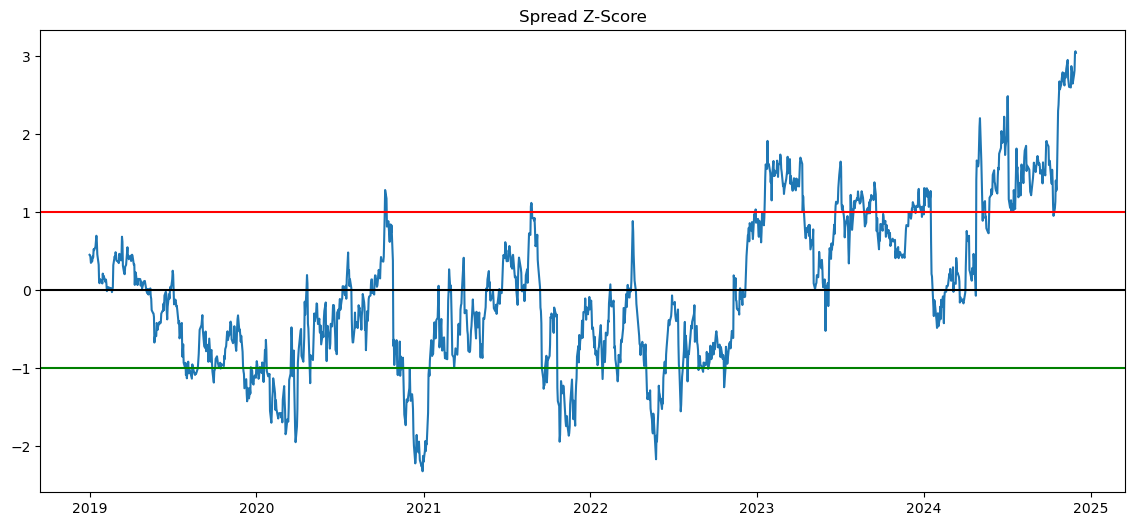

In [6]:
spread = data[assets[0]] - hedge_ratio * data[assets[1]]
mean = spread.mean()
std = spread.std()
zscore = (spread - mean) / std

plt.plot(zscore)
plt.axhline(1, color='r')
plt.axhline(-1, color='g')
plt.axhline(0, color='black')
plt.title("Spread Z-Score")
plt.show()

In [7]:
entry_long = zscore < -1   # buy spread
entry_short = zscore > 1   # short spread
exit_trade = (zscore > -0.5) & (zscore < 0.5)

positions = np.where(entry_long, 1,
            np.where(entry_short, -1, 0))

positions = pd.Series(positions, index=spread.index)

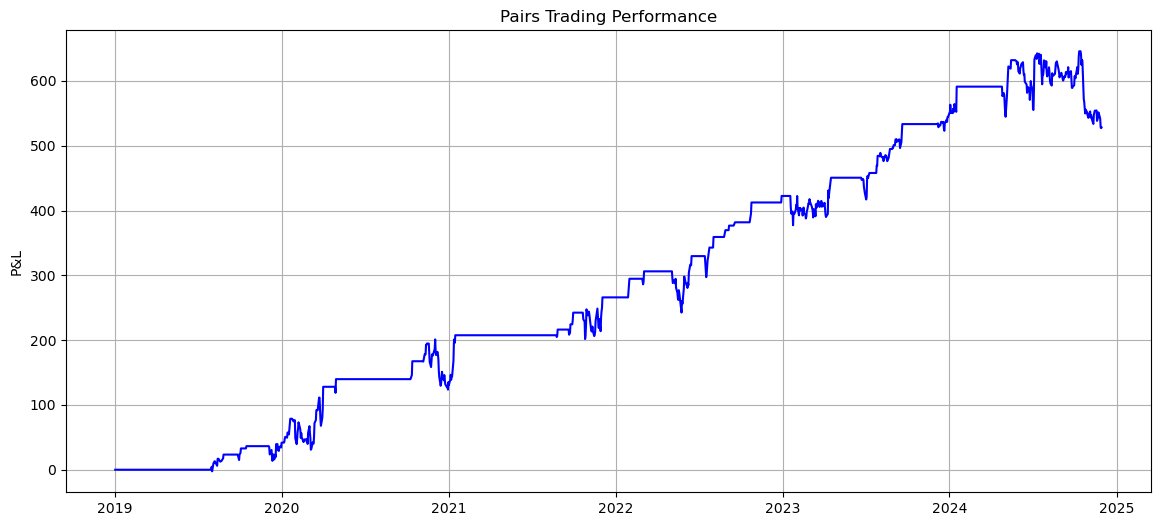

Final P&L: 528.34


In [8]:
returns = spread.diff().fillna(0)
pnl = (positions.shift(1) * returns).cumsum()

plt.plot(pnl, color='blue')
plt.title("Pairs Trading Performance")
plt.ylabel("P&L")
plt.grid(True)
plt.show()

final_pnl = pnl.iloc[-1]
print(f"Final P&L: {final_pnl:.2f}")